In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

from problems import create_3SAT_H_and_psi
import methods

In [2]:
num_qubits = 7

# Load the instances
instances = np.loadtxt("dataset/sat%s.txt"%num_qubits).astype(np.int_)

# Pick the first instance just for demonstrations
H_initial, H_final, psi_initial, psi_final = create_3SAT_H_and_psi(num_qubits,instances[0])

In [3]:
Ts = np.linspace(4, 500, 50)
obsv2, fidv2 = methods.mcts_v2(Ts[-1], num_qubits, 5, 10, H_initial, H_final, psi_initial, psi_final, ncandidates=100, cost_function_type='fidelity')
print(obsv2, fidv2)

[ 0.    0.04 -0.13  0.13  0.  ] 0.1278375834269924


In [4]:
#def mcts(data, n_qubit, T, num_frequency_components, num_trotter_steps, H0, Hf, psi0, psif, ncandidates, cost_function_type='energy', annealing_type='analog', optimization_space='frequency'):
Ts = np.linspace(4, 500, 50)
obs, fid = methods.mcts(Ts[-1], num_qubits, 5, 10, H_initial, H_final, psi_initial, psi_final, ncandidates=100, cost_function_type='fidelity')
print(obs, fid)

Num rounds:  3
[[ 0.    0.07 -0.08  0.   -0.13]] 0.2046157663430354


## Linear solver demo

In [5]:
# Solve using the Linear Method
Ts = np.linspace(4, 500, 50)
fidelities = []
energies = []
for T in tqdm.tqdm(Ts):
    energy, fidelity = methods.linear(5, T, H_initial, H_final, psi_initial, psi_final)
    energies.append(energy[-1])
    fidelities.append(fidelity[-1])

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Text(0, 0.5, 'energy')

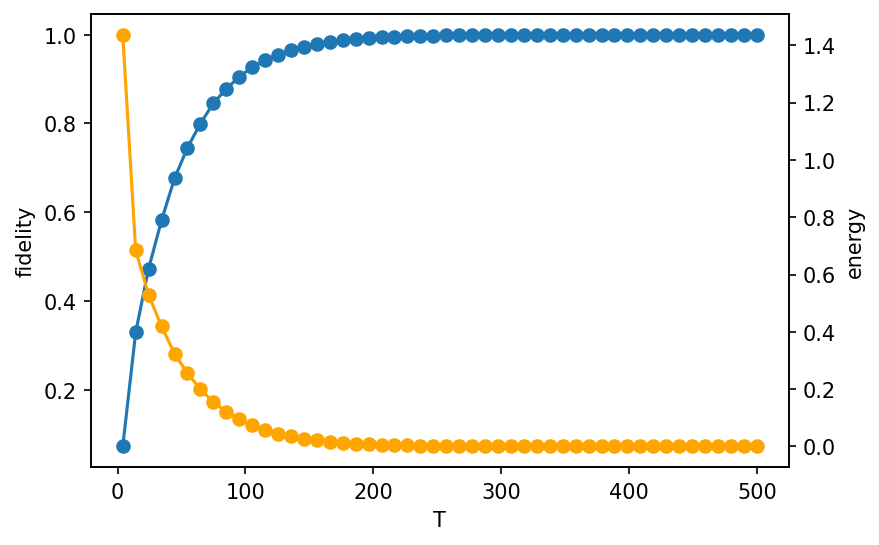

In [6]:
fig, ax = plt.subplots(dpi=150)
ax.plot(Ts, np.array(fidelities), '-o')

ax.set_xlabel("T")
ax.set_ylabel("fidelity")

ax2 = ax.twinx()
ax2.plot(Ts, energies, '-o', c='orange')
ax2.set_ylabel("energy")

## MCTS

In [10]:
print(obs, fid3)

[[ 0.14  0.19  0.03  0.04 -0.18]] 0.18113783245147366
